# 🧩 Experimento: XOR con Mini-Batch y Primer Momento

Este experimento implementa desde cero una red neuronal multicapa mínima para aprender la función lógica **XOR**, demostrando tres conceptos esenciales del aprendizaje profundo:

| Concepto | Descripción |
|-----------|--------------|
| **XOR (exclusive-OR)** | Función no lineal clásica que devuelve 1 solo si las entradas son distintas. No puede resolverse con un modelo lineal, por lo que exige una capa oculta con activación no lineal. |
| **Mini-Batch Gradient Descent** | Estrategia de entrenamiento que usa subconjuntos pequeños del dataset (mini-batches) para calcular el gradiente y actualizar los pesos. Balancea estabilidad (batch) y velocidad (stochastic). |
| **Primer Momento (Momentum)** | Técnica que acumula una “velocidad” de actualización basada en gradientes anteriores, suavizando el descenso y acelerando la convergencia. Se define como:<br>\\( v_t = \epsilon v_{t-1} + \eta \nabla L \\),  luego \\( W_t = W_{t-1} - v_t \\). |

### 🔧 Arquitectura
**Topología:** 2-2-1  
Dos neuronas de entrada (x₁, x₂), dos ocultas con activación sigmoide y una neurona de salida también sigmoide.  
El objetivo es que la red aprenda la frontera no lineal que separa los casos XOR.

### 🔍 Visualizaciones
- **Curva de MSE:** mide la caída del error durante el entrenamiento.  
- **Frontera de decisión:** región aprendida por la red para clasificar (0,1) vs (1,0).  
- **Matriz de confusión:** validación del desempeño final.  
- **Distribución de probabilidades:** cómo el modelo separa ambas clases.  
- **ROC / PR:** métricas de comportamiento como clasificador binario.

> En síntesis: el notebook **demuestra cómo una red mínima, entrenada con mini-batches y momentum, puede aprender una relación no lineal imposible para un perceptrón simple.**

In [38]:
import numpy as np
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from IPython.display import display, HTML
import pandas as pd

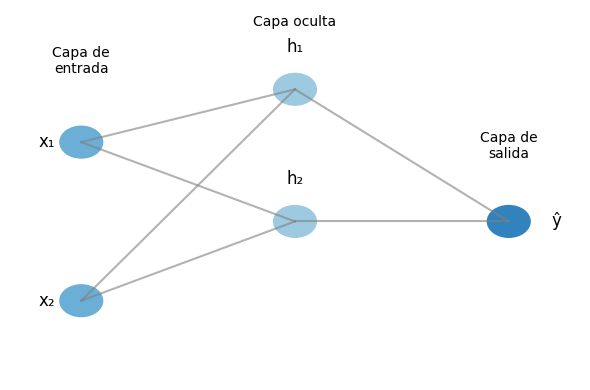

In [39]:
# Función para graficar la arquitectura de la red neuronal para el problema XOR 

def plot_xor_architecture():
    fig, ax = plt.subplots(figsize=(6,4))
    ax.axis("off")

    # Coordenadas aproximadas
    input_neurons = [(0, 1.5), (0, -1.5)]
    hidden_neurons = [(3, 2.5), (3, 0)]
    output_neuron = [(6, 0)]

    # Conexiones
    for (x1, y1) in input_neurons:
        for (x2, y2) in hidden_neurons:
            ax.plot([x1, x2], [y1, y2], color="gray", lw=1.5, alpha=0.6)
    for (x1, y1) in hidden_neurons:
        ax.plot([x1, 6], [y1, 0], color="gray", lw=1.5, alpha=0.6)

    # Nodos
    for (x,y) in input_neurons:
        ax.add_artist(plt.Circle((x,y), 0.3, color="#6baed6"))
    for (x,y) in hidden_neurons:
        ax.add_artist(plt.Circle((x,y), 0.3, color="#9ecae1"))
    for (x,y) in output_neuron:
        ax.add_artist(plt.Circle((x,y), 0.3, color="#3182bd"))

    # Labels
    ax.text(-0.6, 1.5, "x₁", va="center", fontsize=12)
    ax.text(-0.6, -1.5, "x₂", va="center", fontsize=12)
    ax.text(3, 3.2, "h₁", ha="center", fontsize=12)
    ax.text(3, 0.7, "h₂", ha="center", fontsize=12)
    ax.text(6.6, 0, "ŷ", va="center", fontsize=12)

    ax.text(0, 2.8, "Capa de\nentrada", ha="center", fontsize=10)
    ax.text(3, 3.7, "Capa oculta", ha="center", fontsize=10)
    ax.text(6, 1.2, "Capa de\nsalida", ha="center", fontsize=10)

    ax.set_xlim(-1, 7)
    ax.set_ylim(-3, 4)
    plt.tight_layout()
    plt.show()

plot_xor_architecture()


In [40]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [41]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = [0,1,1,0]

In [42]:
batch_size=2
n = 4
n_epochs = 20000
lr = 0.1
epsilon = 0.2

V1_1 = np.random.uniform(0, 1, size=3) * 0
V1_2 = np.random.uniform(0, 1, size=3) * 0
V2_1 = np.random.uniform(0, 1, size=3) * 0

W1_1 = np.random.uniform(0, 1, size=3) # W1_1 dimmension = [m+1] includes the constant term
W1_2 = np.random.uniform(0, 1, size=3) # W1_2 dimmension = [m+1] includes the constant term
W2_1 = np.random.uniform(0, 1, size=3) # W2_1 dimmension = [3] includes the constant term

for epoch in range(n_epochs):

  mse=0

  idx = np.random.permutation(n)

  for batch_start in range(0,n,batch_size):
      batch_end = batch_start + batch_size

      x_batch = X[batch_start:batch_end] # x_batch dimmension = [b,m]
      y_batch = y[batch_start:batch_end] # y_batch dimmension = [b]

      x_batch=np.append(x_batch, np.ones(shape=(x_batch.shape[0],1)), axis = 1) # x_batch dimmension = [b,m+1] includes the constant term

      z1 = x_batch @ W1_1.T # x_batch dimmenion = [b, m+1] | W1_1.T dimmension = [1,m+1] | z1 dimmension = [b]
      a1 = sigmoid(z1).reshape(-1,1) # a1 dimmension = [b]

      z2 = x_batch @ W1_2.T # x_batch dimmenion = [b, m+1] | W1_2.T dimmension = [1,m+1] | z2 dimmension = [b]
      a2 = sigmoid(z2).reshape(-1,1) # a2 dimmension = [b]

      x1_2 = np.concatenate([a1,a2, np.ones(shape=(2,1))],axis=1) # x1_2 dimmension = [b , 3]
      z3 = x1_2 @ W2_1.T # x_batch dimmenion = [b, 3] | W2_1.T dimmension = [1,3] | z3 dimmension = [b]
      a3 = sigmoid(z3) # a3 dimmenion = [b]

      prediction = a3

      error = y_batch - prediction # error dimmension = [b]
      mse = mse + np.power(error,2).mean() # MSE dimmension = [1]

      grad_W2_1 = -2 * (error * sigmoid(z3) * (1-sigmoid(z3))).reshape(-1,1) * x1_2 # error dimmension = [1] | x1_2 dimmension = [b , 3] | z3 dimmension = [b] -> broadcast to [b,3] | grad_W2_1 dimmension = [b,3]
      grad_W1_2 = -2 * (error * sigmoid(z3) * (1-sigmoid(z3)) * sigmoid(z2) * (1-sigmoid(z2))*W2_1[1]).reshape(-1,1) * x_batch # error dimmension = [1] | W2_1[1] dimmension = [1] | x_batch dimmension = [b , m+1] | z2 dimmension = [b] -> broadcast to [b,m+1] | z3 dimmension = [b] -> broadcast to [b,m+1] | grad_W2_1 dimmension = [b,m+1]
      grad_W1_1 = -2 * (error * sigmoid(z3) * (1-sigmoid(z3)) * sigmoid(z1) * (1-sigmoid(z1))*W2_1[0]).reshape(-1,1) * x_batch # error dimmension = [1] | W2_1[0] dimmension = [1] | x_batch dimmension = [b , m+1] | z1 dimmension = [b] -> broadcast to [b,m+1] | z3 dimmension = [b] -> broadcast to [b,m+1] | grad_W1_1 dimmension = [b,m+1]

      # Back propagation
      V2_1 = (epsilon * V2_1) + (lr * grad_W2_1.mean(axis=0)) # grad_W2_1.mean dimmension = [3] | V2_1 dimmension = [3]
      W2_1 = W2_1 - V2_1 # V2_1 dimmension = [3] | W2_1 dimmension = [3]

      V1_2 = (epsilon * V1_2) + (lr * grad_W1_2.mean(axis=0)) # grad_W1_2.mean dimmension = [m+1] | V1_2 dimmension = [m+1]
      W1_2 = W1_2 - V1_2 # V1_2 dimmension = [m+1] | W1_2 dimmension = [m+1]

      V1_1 = (epsilon * V1_1) + (lr * grad_W1_1.mean(axis=0)) # grad_W1_1.mean dimmension = [m+1] | V1_1 dimmension = [m+1]
      W1_1 = W1_1 - V1_1 # V1_1 dimmension = [m+1] | W1_1 dimmension = [m+1]


  if (epoch % (n_epochs/10)) == 0:
    print("Epoch ",epoch," MSE: ",mse)

Epoch  0  MSE:  0.705593842375869
Epoch  2000  MSE:  0.4361704456008
Epoch  4000  MSE:  0.1248020452099431
Epoch  6000  MSE:  0.014518052040895
Epoch  8000  MSE:  0.006741891712410977
Epoch  10000  MSE:  0.004283770407384337
Epoch  12000  MSE:  0.003109187631713684
Epoch  14000  MSE:  0.00242816496786526
Epoch  16000  MSE:  0.0019860945536148305
Epoch  18000  MSE:  0.001677032073273878


In [43]:
for batch_start in range(0,n,batch_size):
      batch_end = batch_start + batch_size

      x_batch = X[batch_start:batch_end]
      y_batch = y[batch_start:batch_end]

      x_batch=np.append(x_batch, np.ones(shape=(x_batch.shape[0],1)), axis = 1)

      z1 = x_batch @ W1_1.T
      a1 = sigmoid(z1).reshape(-1,1)

      z2 = x_batch @ W1_2.T
      a2 = sigmoid(z2).reshape(-1,1)

      x1_2 = np.concatenate([a1,a2, np.ones(shape=(2,1))],axis=1)
      z3 = x1_2 @ W2_1.T
      a3 = sigmoid(z3)
      prediction = a3

      print(f"Reales {y_batch} | Predicciones {prediction}")


Reales [0, 1] | Predicciones [0.02925672 0.97429599]
Reales [1, 0] | Predicciones [0.97436723 0.026923  ]


In [44]:
# OM: reformulado

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def mse(y_true, y_pred):
    e = y_true - y_pred
    return np.mean(e**2)

class MLP_MSE_Sigmoid:
    """
    MLP (m -> H -> 1) con:
      - activación sigmoide en oculta y salida
      - pérdida MSE
      - SGD con momentum
      - mini-batch
    Pesos con bias embebido (columnas extras de 1s).
    W1: (m+1, H)  | W2: (H+1, 1)
    """

    def __init__(self, m, hidden_units, rng_seed=0):
        self.m = m
        self.H = hidden_units
        self.rng = np.random.default_rng(rng_seed)
        self.loss_history = []

        # Inicialización leve tipo Xavier para sigmoide
        lim1 = np.sqrt(6/(m + hidden_units))
        self.W1 = self.rng.uniform(-lim1, lim1, size=(m+1, hidden_units))  # +1 por bias

        lim2 = np.sqrt(6/(hidden_units + 1))
        self.W2 = self.rng.uniform(-lim2, lim2, size=(hidden_units+1, 1))  # +1 por bias

        # Momentos
        self.V1 = np.zeros_like(self.W1)
        self.V2 = np.zeros_like(self.W2)

    def _forward(self, Xb):
        """
        Xb: (b, m) sin bias; internamente se agrega columna de 1s.
        Devuelve:
          Z1 (b,H), A1 (b,H), Z2 (b,1), A2 (b,1)
        """
        b = Xb.shape[0]
        Xb_bias = np.concatenate([Xb, np.ones((b, 1))], axis=1)   # (b, m+1)

        Z1 = Xb_bias @ self.W1             # (b, H)
        A1 = sigmoid(Z1)                   # (b, H)

        A1_bias = np.concatenate([A1, np.ones((b, 1))], axis=1)   # (b, H+1)
        Z2 = A1_bias @ self.W2             # (b, 1)
        A2 = sigmoid(Z2)                   # (b, 1)

        return Xb_bias, Z1, A1, A1_bias, Z2, A2

    def predict_proba(self, X):
        _, _, _, _, _, A2 = self._forward(X)
        return A2  # (n,1)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

    def fit(self, X, y, lr=lr, momentum=epsilon, batch_size=batch_size, epochs=n_epochs,
            shuffle=True, verbose_every=0, early_stopping=None):
        """
        X: (n, m)   y: (n,) o (n,1) en [0,1]
        early_stopping: dict opcional, ej:
            {'patience': 50, 'min_delta': 1e-6}
        """
        y = y.reshape(-1, 1)
        n = X.shape[0]
        num_batches = int(np.ceil(n / batch_size))

        best_loss = np.inf
        best_params = None
        patience_left = early_stopping['patience'] if early_stopping else None
        min_delta = early_stopping['min_delta'] if early_stopping else 0.0

        for epoch in range(1, epochs+1):
            # barajar
            if shuffle:
                idx = np.random.permutation(n)
                X_epoch = X[idx]
                y_epoch = y[idx]
            else:
                X_epoch, y_epoch = X, y

            epoch_loss = 0.0

            for bidx in range(0, n, batch_size):
                Xb = X_epoch[bidx:bidx+batch_size]
                yb = y_epoch[bidx:bidx+batch_size]

                # ----- Forward -----
                Xb_bias, Z1, A1, A1_bias, Z2, A2 = self._forward(Xb)

                # ----- Loss -----
                err = yb - A2                     # (b,1)
                batch_mse = np.mean(err**2)
                epoch_loss += batch_mse

                # ----- Backprop (MSE + sigmoide) -----
                # dL/dA2 = -2*(yb - A2) ; A2' = A2*(1-A2)
                dZ2 = -2 * err * (A2 * (1 - A2))             # (b,1)
                # grad W2 = (A1_bias^T @ dZ2) / b
                gW2 = (A1_bias.T @ dZ2) / Xb.shape[0]        # (H+1,1)

                # Propagar a la oculta: dA1 = dZ2 @ W2[:-1].T
                dA1 = dZ2 @ self.W2[:-1].T                   # (b,H)
                dZ1 = dA1 * (A1 * (1 - A1))                  # (b,H)
                # grad W1 = (Xb_bias^T @ dZ1) / b
                gW1 = (Xb_bias.T @ dZ1) / Xb.shape[0]        # (m+1,H)

                # ----- Actualización con momentum -----
                self.V2 = epsilon * self.V2 + lr * gW2
                self.W2 = self.W2 - self.V2

                self.V1 = epsilon * self.V1 + lr * gW1
                self.W1 = self.W1 - self.V1

            epoch_loss /= num_batches
            self.loss_history.append(epoch_loss)

            # Early stopping opcional
            if early_stopping:
                if epoch_loss + min_delta < best_loss:
                    best_loss = epoch_loss
                    best_params = (self.W1.copy(), self.W2.copy(),
                                   self.V1.copy(), self.V2.copy())
                    patience_left = early_stopping['patience']
                else:
                    patience_left -= 1
                    if patience_left <= 0:
                        # Restaurar mejores pesos
                        if best_params is not None:
                            self.W1, self.W2, self.V1, self.V2 = best_params
                        if verbose_every:
                            print(f"Stopped early at epoch {epoch} | best MSE {best_loss:.6f}")
                        break

            if verbose_every and (epoch % verbose_every == 0 or epoch == 1):
                print(f"Epoch {epoch:5d} | MSE {epoch_loss:.6f}")

        return self


In [45]:
# Datos de juguete: XOR (m=2), etiquetas en {0,1}
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([0,1,1,0], dtype=float)

model = MLP_MSE_Sigmoid(m=2, hidden_units=2, rng_seed=42)
model.fit(X, y, lr=lr, momentum=epsilon, batch_size=batch_size, epochs=n_epochs, verbose_every=1000)

probs = model.predict_proba(X).ravel()
preds = model.predict(X).ravel()
print("probs:", np.round(probs, 3))
print("preds:", preds.astype(int))


Epoch     1 | MSE 0.252447
Epoch  1000 | MSE 0.246793
Epoch  2000 | MSE 0.208496
Epoch  3000 | MSE 0.178759
Epoch  4000 | MSE 0.115352
Epoch  5000 | MSE 0.021221
Epoch  6000 | MSE 0.008701
Epoch  7000 | MSE 0.005212
Epoch  8000 | MSE 0.003670
Epoch  9000 | MSE 0.002807
Epoch 10000 | MSE 0.002260
Epoch 11000 | MSE 0.001889
Epoch 12000 | MSE 0.001617
Epoch 13000 | MSE 0.001412
Epoch 14000 | MSE 0.001252
Epoch 15000 | MSE 0.001124
Epoch 16000 | MSE 0.001019
Epoch 17000 | MSE 0.000931
Epoch 18000 | MSE 0.000857
Epoch 19000 | MSE 0.000794
Epoch 20000 | MSE 0.000739
probs: [0.029 0.974 0.974 0.027]
preds: [0 1 1 0]


In [46]:
# Curva de entrenamiento (MSE vs época)

def plot_training_curve(model):
    if not hasattr(model, "loss_history") or len(model.loss_history) == 0:
        raise ValueError("El modelo no tiene loss_history. ¿Agregaste el parche?")
    plt.figure()
    plt.plot(np.arange(1, len(model.loss_history)+1), model.loss_history)
    plt.xlabel("Época")
    plt.ylabel("MSE")
    plt.title("Curva de entrenamiento (MSE)")
    plt.show()

In [ ]:
# Frontera de decisión (solo para m=2)

def plot_decision_boundary(model, X, y, padding=0.5, step=0.01, threshold=0.5):
    assert X.shape[1] == 2, "La frontera de decisión requiere X con 2 features."

    x_min, x_max = X[:,0].min()-padding, X[:,0].max()+padding
    y_min, y_max = X[:,1].min()-padding, X[:,1].max()+padding

    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid).reshape(xx.shape)

    plt.figure()
    # regiones por probabilidad
    cs = plt.contourf(xx, yy, probs, alpha=0.6, levels=50)
    plt.colorbar(cs, label="P(y=1)")

    # puntos reales
    y_bin = y.reshape(-1)
    plt.scatter(X[y_bin==0,0], X[y_bin==0,1], s=30, label="Clase 0")
    plt.scatter(X[y_bin==1,0], X[y_bin==1,1], s=30, marker="x", label="Clase 1")

    # línea de umbral 0.5
    plt.contour(xx, yy, probs, levels=[threshold], linewidths=2)

    plt.title("Frontera de decisión")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.legend()
    plt.show()

In [48]:
# Matriz de confusión + métricas rápidas

def plot_confusion_and_metrics(model, X, y, threshold=0.5):
    y_true = y.reshape(-1).astype(int)
    y_pred = model.predict(X, threshold=threshold).reshape(-1).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])

    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Matriz de confusión")
    plt.xticks([0,1], ["Pred 0", "Pred 1"])
    plt.yticks([0,1], ["Real 0", "Real 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicción"); plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1:        {f1:.3f}")

In [49]:
# Distribución de probabilidades por clase
def plot_proba_hist(model, X, y, bins=20):
    probs = model.predict_proba(X).reshape(-1)
    y_true = y.reshape(-1).astype(int)

    plt.figure()
    plt.hist(probs[y_true==0], bins=bins, alpha=0.6, label="Clase 0")
    plt.hist(probs[y_true==1], bins=bins, alpha=0.6, label="Clase 1")
    plt.xlabel("P(y=1)")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de probabilidades por clase")
    plt.legend()
    plt.show()

In [50]:
# ROC y PR curves

def plot_roc_pr(model, X, y):
    y_true = y.reshape(-1).astype(int)
    scores = model.predict_proba(X).reshape(-1)

    # ROC
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC (AUC={roc_auc:.3f})")
    plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(rec, prec)
    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall (AUC={pr_auc:.3f})")
    plt.show()

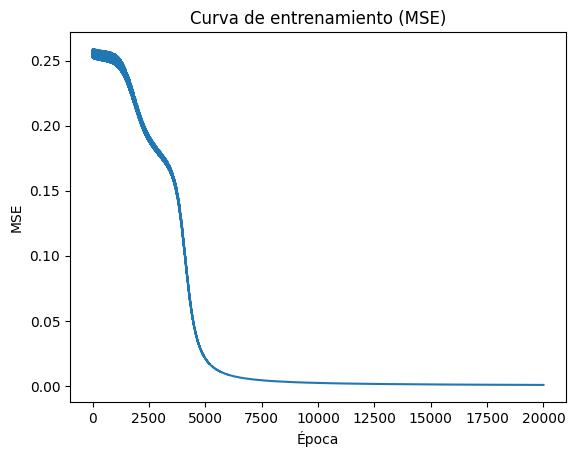

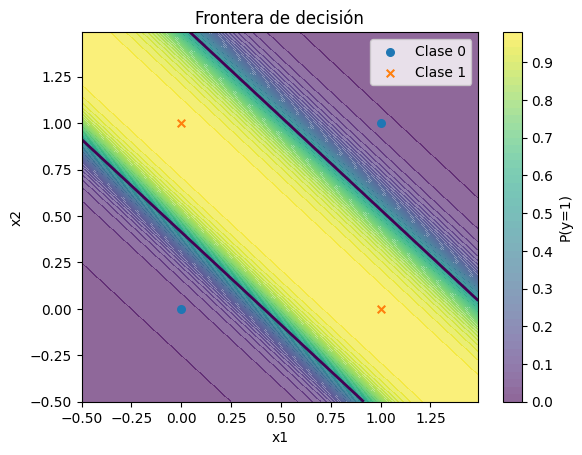

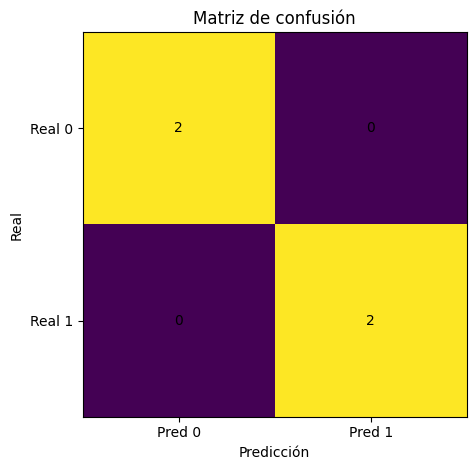

Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1:        1.000


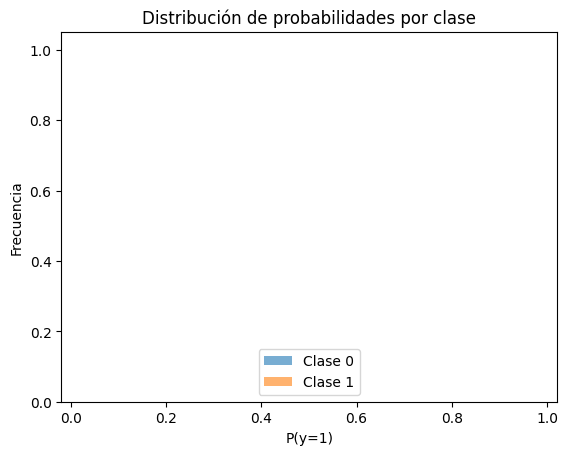

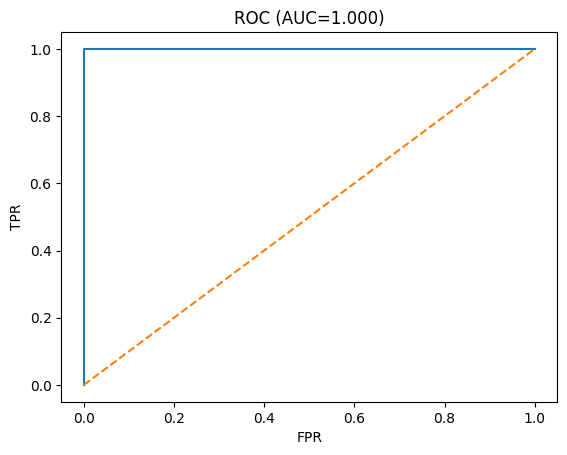

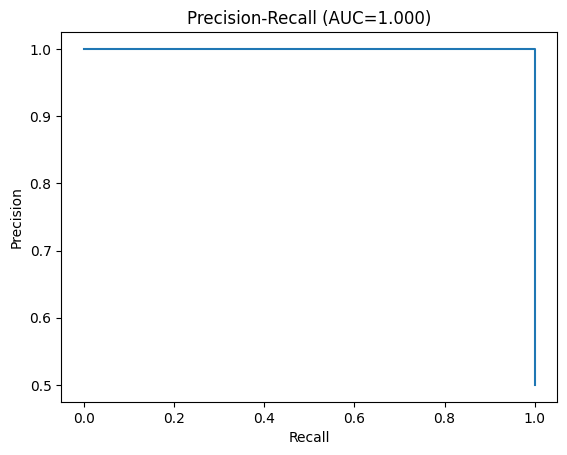

In [51]:
# Ejemplo rápido (XOR)
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([0,1,1,0], dtype=float)

model = MLP_MSE_Sigmoid(m=2, hidden_units=2, rng_seed=42)
model.fit(X, y, lr=lr, momentum=epsilon, batch_size=batch_size, epochs=n_epochs, verbose_every=0)

plot_training_curve(model)
plot_decision_boundary(model, X, y)
plot_confusion_and_metrics(model, X, y)
plot_proba_hist(model, X, y)
plot_roc_pr(model, X, y)

In [52]:
# Función para graficar la arquitectura de la red neuronal XOR con pesos actuales

def plot_xor_architecture_with_weights(model, decimals=3, show=True, save=None, show_momentum=True):
    W1 = np.asarray(model.W1); W2 = np.asarray(model.W2)
    if W1.ndim == 1 and W1.size == 6: W1 = W1.reshape(3,2)
    if W2.ndim == 1 and W2.size == 3: W2 = W2.reshape(3,1)
    if W1.shape != (3,2) or W2.shape != (3,1):
        raise ValueError(f"Esperaba W1=(3,2), W2=(3,1); recibí {W1.shape}, {W2.shape}")

    W1r = np.round(W1, decimals); W2r = np.round(W2, decimals)
    w_x1_h1, w_x1_h2 = W1r[0,0], W1r[0,1]
    w_x2_h1, w_x2_h2 = W1r[1,0], W1r[1,1]
    b_h1, b_h2 = W1r[2,0], W1r[2,1]
    w_h1_y, w_h2_y = W2r[0,0], W2r[1,0]
    b_y = W2r[2,0]

    fig, ax = plt.subplots(figsize=(8,5))
    ax.axis("off")

    x_in, x_hid, x_out = 0, 3, 6
    node_x1 = (x_in,  1.5, "x₁")
    node_x2 = (x_in, -1.5, "x₂")
    node_h1 = (x_hid, 2.5, "h₁")
    node_h2 = (x_hid, 0.0, "h₂")
    node_out = (x_out, 0.0, "ŷ")

    def draw_node(x, y, label):
        circ = plt.Circle((x,y), 0.35, fill=False, linewidth=2)
        ax.add_patch(circ)
        ax.text(x, y, label, ha="center", va="center", fontsize=11)

    for x,y,lbl in [node_x1, node_x2, node_h1, node_h2, node_out]:
        draw_node(x,y,lbl)

    def arrow(p_from, p_to):
        ax.annotate("", xy=p_to, xytext=p_from,
                    arrowprops=dict(arrowstyle="->", linewidth=1.5))
    def right_of(x,y): return (x+0.35, y)
    def left_of(x,y):  return (x-0.35, y)

    # Conexiones
    arrow(right_of(*node_x1[:2]), left_of(*node_h1[:2]))
    arrow(right_of(*node_x2[:2]), left_of(*node_h1[:2]))
    arrow(right_of(*node_x1[:2]), left_of(*node_h2[:2]))
    arrow(right_of(*node_x2[:2]), left_of(*node_h2[:2]))
    arrow(right_of(*node_h1[:2]), left_of(*node_out[:2]))
    arrow(right_of(*node_h2[:2]), left_of(*node_out[:2]))

    # Etiquetas: bbox SÍ, fontsize por separado
    kw = dict(bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1.0))

    ax.text(1.55,  2.10, f"{w_x1_h1}", ha="center", va="center", fontsize=9, **kw)
    ax.text(1.55,  0.45, f"{w_x2_h1}", ha="center", va="center", fontsize=9, **kw)

    ax.text(1.55,  0.95, f"{w_x1_h2}", ha="center", va="center", fontsize=9, **kw)
    ax.text(1.55, -1.05, f"{w_x2_h2}", ha="center", va="center", fontsize=9, **kw)

    ax.text(4.55,  1.15, f"{w_h1_y}", ha="center", va="center", fontsize=9, **kw)
    ax.text(4.55, -0.35, f"{w_h2_y}", ha="center", va="center", fontsize=9, **kw)

    # Bias
    ax.text(x_hid-0.75, 3.25, f"bₕ₁={b_h1}", fontsize=9, **kw)
    ax.text(x_hid-0.75, 0.75, f"bₕ₂={b_h2}", fontsize=9, **kw)
    ax.text(x_out-0.75, 1.20, f"b_y={b_y}",  fontsize=9, **kw)

    # Títulos
    ax.text(x_in,  3.8, "Entrada", ha="center", fontsize=10)
    ax.text(x_hid, 3.8, "Capa oculta (sigmoid)", ha="center", fontsize=10)
    ax.text(x_out, 3.8, "Salida (sigmoid)", ha="center", fontsize=10)

    # Momentum (opcional)
    if show_momentum and hasattr(model, "V1") and hasattr(model, "V2"):
        try:
            V1r = np.round(np.asarray(model.V1), decimals)
            V2r = np.round(np.asarray(model.V2), decimals)
            ax.text(0.15, -3.2, f"Momentum:\nV1=\n{V1r}\nV2=\n{V2r}",
                    ha="left", va="center", fontsize=8, **kw)
        except Exception:
            pass

    ax.set_xlim(-0.5, 7)
    ax.set_ylim(-3.5, 4)
    plt.tight_layout()

    if save:
        fig.savefig(save, dpi=160)

    if show:
        display(fig)   # muestra una sola vez
    plt.close(fig)

In [53]:
print("W1:", type(model.W1), np.asarray(model.W1).shape)
print("W2:", type(model.W2), np.asarray(model.W2).shape)

W1: <class 'numpy.ndarray'> (3, 2)
W2: <class 'numpy.ndarray'> (3, 1)


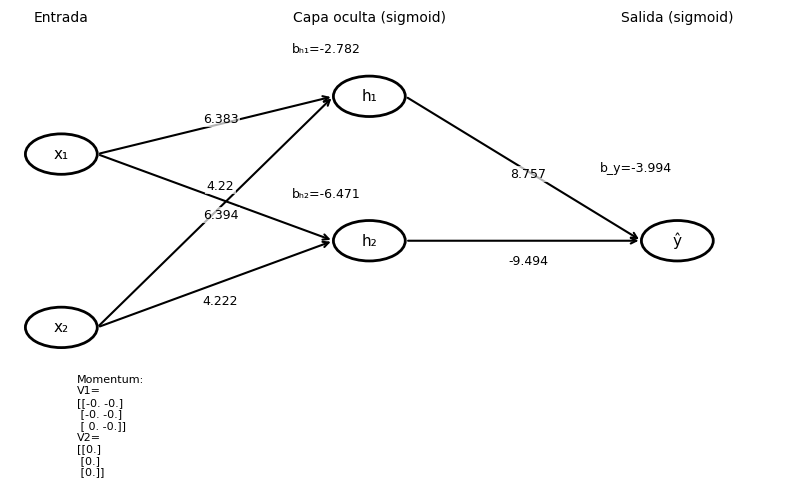

In [54]:
model = MLP_MSE_Sigmoid(m=2, hidden_units=2, rng_seed=42)
model.fit(X, y, lr=lr, momentum=epsilon, batch_size=batch_size, epochs=n_epochs, verbose_every=0)

# Grafica del diagrama con pesos actuales
plot_xor_architecture_with_weights(model)  # muestra en la celda

In [55]:
# Resumen tabular de pesos para comprobar

def summarize_xor_weights(model, decimals=3, include_momentum=True, as_print=True):
    """
    Resume los pesos del MLP 2-2-1 (XOR) en tablas:
      - W1: filas = [x1, x2, bias] ; cols = [h1, h2]
      - W2: filas = [h1, h2, bias] ; cols = [y]
    Si include_momentum=True y el modelo tiene V1/V2, también devuelve/imprime esas tablas.
    Parámetros:
      - decimals: redondeo
      - include_momentum: incluye V1/V2 si existen
      - as_print: imprime bonito; si False, solo retorna los DataFrames
    Retorna:
      dict con {'W1': df_w1, 'W2': df_w2, 'V1': df_v1?, 'V2': df_v2?}
    """
    W1 = np.asarray(model.W1); W2 = np.asarray(model.W2)
    if W1.ndim == 1 and W1.size == 6: W1 = W1.reshape(3,2)
    if W2.ndim == 1 and W2.size == 3: W2 = W2.reshape(3,1)

    if W1.shape != (3,2) or W2.shape != (3,1):
        raise ValueError(f"Esperaba W1=(3,2), W2=(3,1); recibí {W1.shape}, {W2.shape}")

    df_w1 = pd.DataFrame(
        np.round(W1, decimals),
        index=["x1", "x2", "bias"],
        columns=["h1", "h2"]
    )
    df_w2 = pd.DataFrame(
        np.round(W2, decimals),
        index=["h1", "h2", "bias"],
        columns=["y"]
    )

    out = {"W1": df_w1, "W2": df_w2}

    if include_momentum and hasattr(model, "V1") and hasattr(model, "V2"):
        V1 = np.asarray(model.V1); V2 = np.asarray(model.V2)
        if V1.ndim == 1 and V1.size == 6: V1 = V1.reshape(3,2)
        if V2.ndim == 1 and V2.size == 3: V2 = V2.reshape(3,1)
        df_v1 = pd.DataFrame(
            np.round(V1, decimals),
            index=["x1", "x2", "bias"],
            columns=["h1", "h2"]
        )
        df_v2 = pd.DataFrame(
            np.round(V2, decimals),
            index=["h1", "h2", "bias"],
            columns=["y"]
        )
        out["V1"] = df_v1
        out["V2"] = df_v2

    if as_print:
        print("=== W1 (entradas → ocultas) ===")
        print(df_w1.to_string())
        print("\n=== W2 (ocultas → salida) ===")
        print(df_w2.to_string())
        if "V1" in out:
            print("\n--- Momentum ---")
            print("V1 (para W1):")
            print(out["V1"].to_string())
            print("\nV2 (para W2):")
            print(out["V2"].to_string())

    return out

In [56]:
# Mostramos los valores tabulares
model.fit(X, y, lr=lr, momentum=epsilon, batch_size=batch_size, epochs=n_epochs, verbose_every=0)

tablas = summarize_xor_weights(model, decimals=4, include_momentum=True, as_print=False)

with pd.option_context('display.max_rows', 20,
                       'display.max_columns', 10,
                       'display.width', 120):
    display(tablas["W1"].style.set_caption("W1: entradas→ocultas").format("{:.4f}"));
    display(tablas["W2"].style.set_caption("W2: ocultas→salida").format("{:.4f}"));

    # 👇 Momentums (si existen en el modelo)
    if "V1" in tablas:
        display(tablas["V1"].style.set_caption("V1 (momentum de W1)").format("{:.4f}"));
    if "V2" in tablas:
        display(tablas["V2"].style.set_caption("V2 (momentum de W2)").format("{:.4f}"));

,h1,h2
x1,6.6175,4.5339
x2,6.6257,4.5357
bias,-2.9410,-6.9562


,y
h1,9.5597
h2,-10.3076
bias,-4.4035


,h1,h2
x1,-0.0000,-0.0000
x2,-0.0000,-0.0000
bias,-0.0000,-0.0000


,y
h1,-0.0000
h2,0.0000
bias,0.0000


In [57]:
# Mapas de calor de las activaciones ocultas
def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def _make_grid(X, padding=0.5, step=0.01):
    x_min, x_max = X[:,0].min()-padding, X[:,0].max()+padding
    y_min, y_max = X[:,1].min()-padding, X[:,1].max()+padding
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, grid

def plot_hidden_activation_h1(model, X, y=None, padding=0.5, step=0.01, show_points=True):
    """
    Mapa de activación de la neurona oculta h1: A1[:,0] = σ(Z1[:,0]).
    """
    # Preparar datos y pesos
    assert X.shape[1] == 2, "Esta función asume m=2."
    W1 = np.asarray(model.W1).reshape(3,2)   # (m+1, H) = (3,2)
    # Grid
    xx, yy, grid = _make_grid(X, padding, step)
    grid_bias = np.concatenate([grid, np.ones((grid.shape[0],1))], axis=1)  # (G, m+1)
    Z1 = grid_bias @ W1                  # (G, 2)
    A1 = _sigmoid(Z1)                    # (G, 2)
    A1_h1 = A1[:,0].reshape(xx.shape)    # activación de h1

    plt.figure()
    cs = plt.contourf(xx, yy, A1_h1, levels=50, alpha=0.8)
    plt.colorbar(cs, label="Activación h1")
    if show_points:
        if y is None:
            plt.scatter(X[:,0], X[:,1], s=25)
        else:
            yb = np.asarray(y).reshape(-1).astype(int)
            plt.scatter(X[yb==0,0], X[yb==0,1], s=25, label="Clase 0")
            plt.scatter(X[yb==1,0], X[yb==1,1], s=25, marker="x", label="Clase 1")
            plt.legend()
    plt.title("Mapa de activación h1 (σ(z1₁))")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

def plot_hidden_activation_h2(model, X, y=None, padding=0.5, step=0.01, show_points=True):
    """
    Mapa de activación de la neurona oculta h2: A1[:,1] = σ(Z1[:,1]).
    """
    assert X.shape[1] == 2, "Esta función asume m=2."
    W1 = np.asarray(model.W1).reshape(3,2)
    xx, yy, grid = _make_grid(X, padding, step)
    grid_bias = np.concatenate([grid, np.ones((grid.shape[0],1))], axis=1)
    Z1 = grid_bias @ W1
    A1 = _sigmoid(Z1)
    A1_h2 = A1[:,1].reshape(xx.shape)

    plt.figure()
    cs = plt.contourf(xx, yy, A1_h2, levels=50, alpha=0.8)
    plt.colorbar(cs, label="Activación h2")
    if show_points:
        if y is None:
            plt.scatter(X[:,0], X[:,1], s=25)
        else:
            yb = np.asarray(y).reshape(-1).astype(int)
            plt.scatter(X[yb==0,0], X[yb==0,1], s=25, label="Clase 0")
            plt.scatter(X[yb==1,0], X[yb==1,1], s=25, marker="x", label="Clase 1")
            plt.legend()
    plt.title("Mapa de activación h2 (σ(z1₂))")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

def plot_output_probability(model, X, y=None, padding=0.5, step=0.01, threshold=0.5, show_points=True):
    """
    Probabilidad de salida P(y=1) sobre el plano (similar a tu frontera de decisión).
    """
    assert X.shape[1] == 2
    xx, yy, grid = _make_grid(X, padding, step)
    probs = model.predict_proba(grid).reshape(xx.shape)

    plt.figure()
    cs = plt.contourf(xx, yy, probs, levels=50, alpha=0.8)
    plt.colorbar(cs, label="P(y=1)")
    plt.contour(xx, yy, probs, levels=[threshold], linewidths=2)
    if show_points:
        if y is None:
            plt.scatter(X[:,0], X[:,1], s=25)
        else:
            yb = np.asarray(y).reshape(-1).astype(int)
            plt.scatter(X[yb==0,0], X[yb==0,1], s=25, label="Clase 0")
            plt.scatter(X[yb==1,0], X[yb==1,1], s=25, marker="x", label="Clase 1")
            plt.legend()
    plt.title("Probabilidad de salida σ(z2)")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

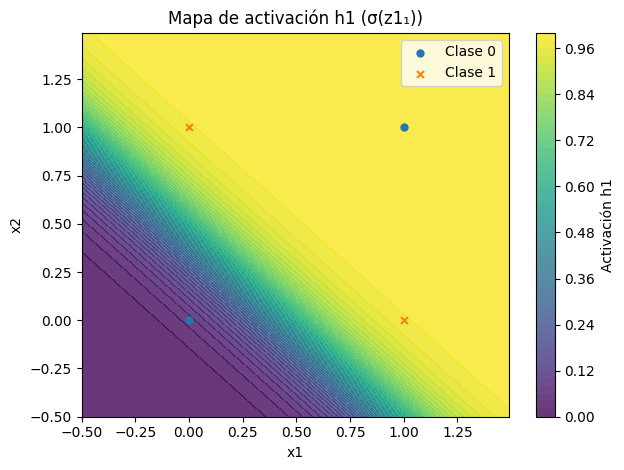

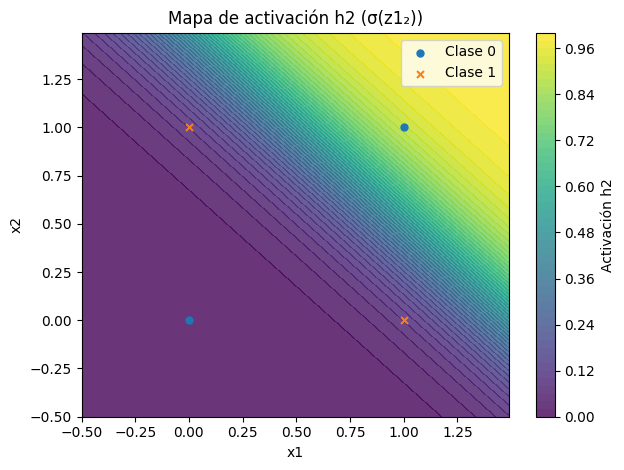

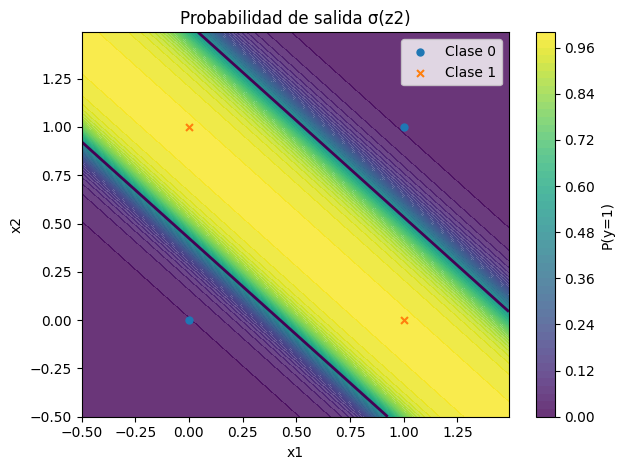

In [58]:
plot_hidden_activation_h1(model, X, y)
plot_hidden_activation_h2(model, X, y)
# (opcional) salida
plot_output_probability(model, X, y, threshold=0.5)